In [1]:
!pip install pandas numpy scikit-learn optuna matplotlib 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import matplotlib.pyplot as plt


/home/queimadas/Desktop/precipitation_mlp/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Carregar os arquivos
df= pd.read_csv("./data/precipitacao_acumulada_diarias_municipios_2023.csv")

# Garantir que a coluna de data seja datetime
df['data'] = pd.to_datetime(df['data_arquivo'])
print(df['data'])

# Ordenar por data
df = df.sort_values(by='data').reset_index(drop=True)

df.head()


0         2023-01-01 12:00:00
1         2023-01-01 12:00:00
2         2023-01-01 12:00:00
3         2023-01-01 12:00:00
4         2023-01-01 12:00:00
                  ...        
1537315   2023-10-03 12:00:00
1537316   2023-10-03 12:00:00
1537317   2023-10-03 12:00:00
1537318   2023-10-03 12:00:00
1537319   2023-10-03 12:00:00
Name: data, Length: 1537320, dtype: datetime64[ns]


,CD_MUN,municipio,estado,data_arquivo,precipitacao_acumulada,data
0,1200385,PLÁCIDO DE CASTRO,ACRE,2023-01-01 12:00:00,0.885,2023-01-01 12:00:00
1,2409506,PEDRA GRANDE,RIO GRANDE DO NORTE,2023-01-01 12:00:00,0.000,2023-01-01 12:00:00
2,2402402,CARNAÚBA DOS DANTAS,RIO GRANDE DO NORTE,2023-01-01 12:00:00,0.000,2023-01-01 12:00:00
3,2411502,SANTO ANTÔNIO,RIO GRANDE DO NORTE,2023-01-01 12:00:00,0.204,2023-01-01 12:00:00
4,2404002,FRUTUOSO GOMES,RIO GRANDE DO NORTE,2023-01-01 12:00:00,0.000,2023-01-01 12:00:00


In [4]:
# Contar valores nulos por coluna
null_counts = df.isnull().sum()
print("Valores nulos por coluna:\n", null_counts)


Valores nulos por coluna:
 CD_MUN                    0
municipio                 0
estado                    0
data_arquivo              0
precipitacao_acumulada    0
data                      0
dtype: int64


In [5]:
import pandas as pd

municipios = [
    "ARARAQUARA",  # município alvo
    "DOIS CÓRREGOS",
    "LUÍS ANTÔNIO",
    "JABOTICABAL",
    "CÂNDIDO RODRIGUES"
]

# Filtrar apenas os municípios desejados
df_filtrado = df[df['municipio'].isin(municipios)].copy()

# Converter coluna de data se ainda não estiver no formato datetime
df_filtrado['data'] = pd.to_datetime(df_filtrado['data'])

# Filtrar períodos desejados
mask_periodos = (
    ((df_filtrado['data'] >= "2023-01-01") & (df_filtrado['data'] < "2023-07-01")) # janeiro a junho
)

df_filtrado = df_filtrado[mask_periodos].copy()

# Ordenar por data para manter sequência temporal
df_filtrado = df_filtrado.sort_values(by="data")

#df_filtrado.head(10)
df_filtrado.tail(10)

,CD_MUN,municipio,estado,data_arquivo,precipitacao_acumulada,data
999515,3514106,DOIS CÓRREGOS,SÃO PAULO,2023-06-29 12:00:00,0.0,2023-06-29 12:00:00
998502,3510104,CÂNDIDO RODRIGUES,SÃO PAULO,2023-06-29 12:00:00,0.0,2023-06-29 12:00:00
998542,3503208,ARARAQUARA,SÃO PAULO,2023-06-29 12:00:00,0.0,2023-06-29 12:00:00
998577,3524303,JABOTICABAL,SÃO PAULO,2023-06-29 12:00:00,0.0,2023-06-29 12:00:00
998732,3527603,LUÍS ANTÔNIO,SÃO PAULO,2023-06-29 12:00:00,0.0,2023-06-29 12:00:00
1004547,3503208,ARARAQUARA,SÃO PAULO,2023-06-30 12:00:00,0.0,2023-06-30 12:00:00
1004653,3514106,DOIS CÓRREGOS,SÃO PAULO,2023-06-30 12:00:00,0.0,2023-06-30 12:00:00
1004183,3510104,CÂNDIDO RODRIGUES,SÃO PAULO,2023-06-30 12:00:00,0.0,2023-06-30 12:00:00
1004258,3527603,LUÍS ANTÔNIO,SÃO PAULO,2023-06-30 12:00:00,0.0,2023-06-30 12:00:00
1005195,3524303,JABOTICABAL,SÃO PAULO,2023-06-30 12:00:00,0.0,2023-06-30 12:00:00


In [6]:
# Pivotar tabela: cada município será uma coluna, datas como índice
df_pivot = df_filtrado.pivot(index='data', columns='municipio', values='precipitacao_acumulada')

# Garantir que não existam datas faltantes no índice
df_pivot = df_pivot.sort_index()

# Definir variáveis
X = df_pivot.drop(columns=["ARARAQUARA"])  # preditores
y = df_pivot["ARARAQUARA"]                 # alvo


In [7]:
def objective(trial):
    # Hiperparâmetros
    hidden_layer_sizes = tuple([
        trial.suggest_int(f"n_neurons_layer_{i}", 5, 50) 
        for i in range(trial.suggest_int("n_layers", 2, 5))
    ])
    alpha = trial.suggest_loguniform("alpha", 1e-2, 1e-1) # L2
    learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-2, 1e-1)
    activation = trial.suggest_categorical("activation", ["tanh", "relu", "logistic", "identity"])

    mlp = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver='adam',
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=200,
        early_stopping=True,
        random_state=42
    )

    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, test_idx in tscv.split(X, y):
        # Garantir que não treinamos com dados de abril, maio e junho de 2023
        if X.index[test_idx].max() >= pd.Timestamp("2023-04-01"):
            break
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        scores.append(mean_squared_error(y_test, y_pred))
    
    return np.mean(scores)


In [14]:
sampler = optuna.samplers.TPESampler(seed = 190)
study = optuna.create_study(direction="minimize", sampler = sampler)
study.optimize(objective, n_trials=350)

print("Melhores parâmetros:", study.best_params)


[I 2025-08-20 09:39:58,221] A new study created in memory with name: no-name-bf55236b-e383-4397-a0b4-e278f152fafc
/tmp/ipykernel_610007/1552848210.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-2, 1e-1) # L2
/tmp/ipykernel_610007/1552848210.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-2, 1e-1)
[I 2025-08-20 09:39:58,239] Trial 0 finished with value: 38.11889562105962 and parameters: {'n_layers': 4, 'n_neurons_layer_0': 33, 'n_neurons_layer_1': 35, 'n_neurons_layer_2': 37, 'n_neurons_layer_3': 43, 'alpha': 0.06632526815919629, 'learning_rate_ini

Melhores parâmetros: {'n_layers': 5, 'n_neurons_layer_0': 17, 'n_neurons_layer_1': 23, 'n_neurons_layer_2': 43, 'n_neurons_layer_3': 26, 'n_neurons_layer_4': 26, 'alpha': 0.03534930993944912, 'learning_rate_init': 0.01938186249319614, 'activation': 'relu'}


In [15]:
best_params = study.best_params

# Reconstruir hidden_layer_sizes
hidden_layers = tuple(best_params[f"n_neurons_layer_{i}"] for i in range(best_params["n_layers"]))

mlp_final = MLPRegressor(
    hidden_layer_sizes=hidden_layers,
    activation=best_params['activation'],  # vem do Optuna
    solver='adam',
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
    max_iter=500,
    early_stopping=True,
    random_state=42
)

# Criar máscara de treino (fev+mar) e teste (abril de 2024)
periodos_treino = (
    ((X.index >= "2023-01-01") & (X.index < "2023-04-01")) # Jan, Fev, Mar 2023
)
periodo_teste = (X.index >= "2023-04-01") & (X.index < "2023-07-01")  # Abril, maio, junho 2024

# Separar treino e teste
X_train, y_train = X[periodos_treino], y[periodos_treino]
X_test, y_test = X[periodo_teste], y[periodo_teste]

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (90, 4)
Tamanho teste: (91, 4)


MAE : 2.55


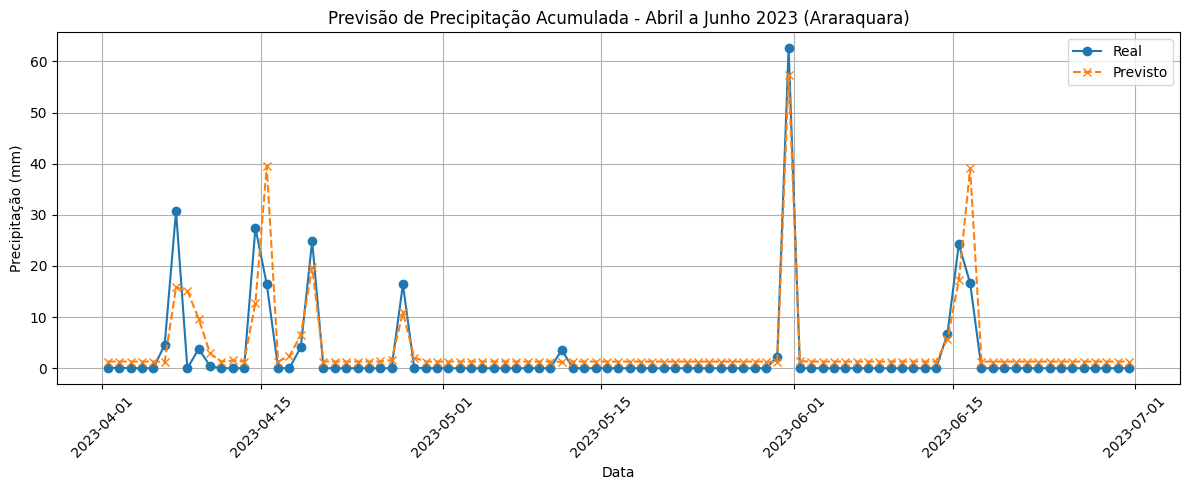

In [16]:
# Treino: Jan+Fev+Mar 2023
# Teste: Abril+Mai+Jun 2023
from sklearn.metrics import mean_absolute_error
import numpy as np

X_train_jan_mar = X[(X.index >= "2023-01-01") & (X.index < "2023-04-01")]
y_train_jan_mar = y[(y.index >= "2023-01-01") & (y.index < "2023-04-01")]

X_test_abril_jun = X[(X.index >= "2023-04-01") & (X.index < "2023-07-01")]
y_test_abril_jun = y[(y.index >= "2023-04-01") & (y.index < "2023-07-01")]

# Treinar modelo
mlp_final.fit(X_train_jan_mar, y_train_jan_mar)

# Previsão
y_pred_abril_jun = mlp_final.predict(X_test_abril_jun)

# Avaliação
mae = mean_absolute_error(y_test_abril_jun, y_pred_abril_jun)
print(f"MAE : {mae:.2f}")

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test_abril_jun.index, y_test_abril_jun, label="Real", marker='o')
plt.plot(y_test_abril_jun.index, y_pred_abril_jun, label="Previsto", marker='x', linestyle='--')
plt.title("Previsão de Precipitação Acumulada - Abril a Junho 2023 (Araraquara)")
plt.xlabel("Data")
plt.ylabel("Precipitação (mm)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
